# MLP
MLP, K=5, epochs=200.
Use lncRNA.
Train set: filter tails.
Valid set: filter none.

In [13]:
from datetime import datetime
print(datetime.now())

2023-04-04 12:22:14.069329


In [14]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = True
FILTER_TAILS_TRAIN  = True
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [16]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [17]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [18]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [19]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-04 12:22:15.562478
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                65664     
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [22]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-04 12:22:15.745639
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-04-04 12:22:34.259147

Training # 1 1
2023-04-04 12:22:34.260815
2023-04-04 12:22:34.261606
Discriminator ZERO -1
Train 1:0 757:668 53.12%
Computed class weights: {0: 1.0666167664670658, 1: 0.9412153236459709}
Valid 1:0 458:412 52.64%
FIT
2023-04-04 12:22:34.340806


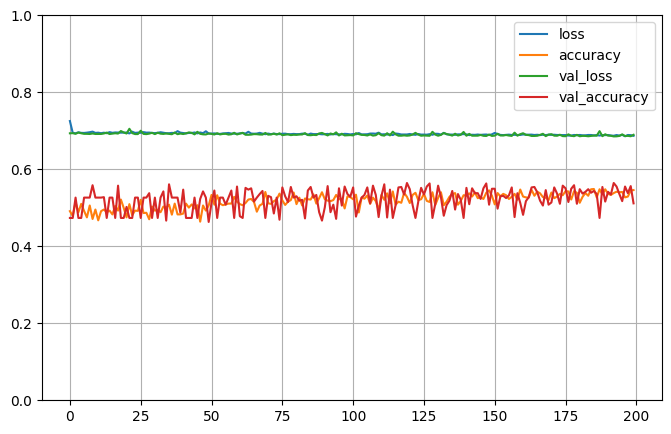


2023-04-04 12:23:16.539170

Testing # 1 1
2023-04-04 12:23:16.540517
2023-04-04 12:23:16.540860
PREDICT
2023-04-04 12:23:16.549148
Test 1:0 458:412 52.64%
Predict 1:0 399:471 45.86%
Test sizes (870, 1025) (870,)
Range of scores: 0.28281724 to 0.5326302
Score threshold 0.5
Confusion matrix
 [[229 183]
 [242 216]]
Normalized matrix
 [[0.26321839 0.21034483]
 [0.27816092 0.24827586]]


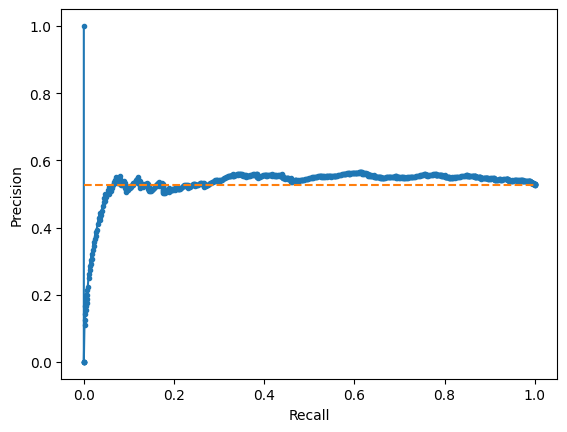

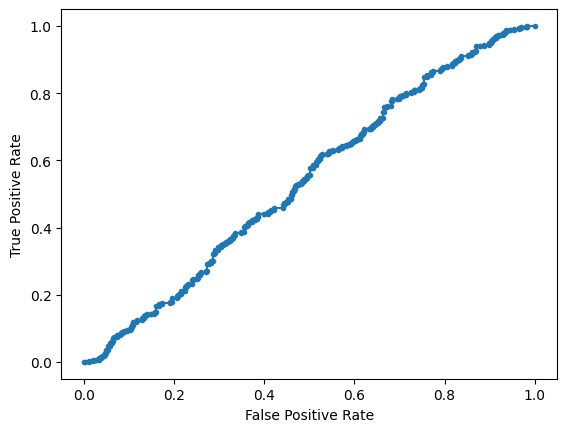

Accuracy: 51.15% Precision: 54.14% Recall: 47.16%
F1: 50.41% MCC: 0.0275
AUPRC: 53.40% AUROC: 53.97%
 accuracy [51.14942528735632]
 precision [54.13533834586466]
 recall [47.161572052401745]
 F1 [50.40840140023337]
 MCC [0.0274969040162806]
 AUPRC [53.401980268217386]
 AUROC [53.965107898418616]
2023-04-04 12:23:17.274796

Training # 1 2
2023-04-04 12:23:17.276379
2023-04-04 12:23:17.276677
Discriminator ZERO -1
Train 1:0 742:639 53.73%
Computed class weights: {0: 1.0805946791862284, 1: 0.9305929919137467}
Valid 1:0 442:442 50.00%
FIT
2023-04-04 12:23:17.354011


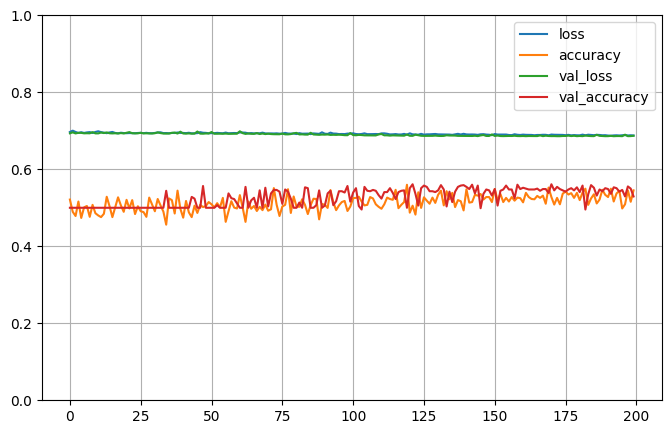


2023-04-04 12:23:58.866947

Testing # 1 2
2023-04-04 12:23:58.867082
2023-04-04 12:23:58.867128
PREDICT
2023-04-04 12:23:58.878068
Test 1:0 442:442 50.00%
Predict 1:0 404:480 45.70%
Test sizes (884, 1025) (884,)
Range of scores: 0.19272956 to 0.5149275
Score threshold 0.5
Confusion matrix
 [[253 189]
 [227 215]]
Normalized matrix
 [[0.2861991  0.2138009 ]
 [0.25678733 0.24321267]]


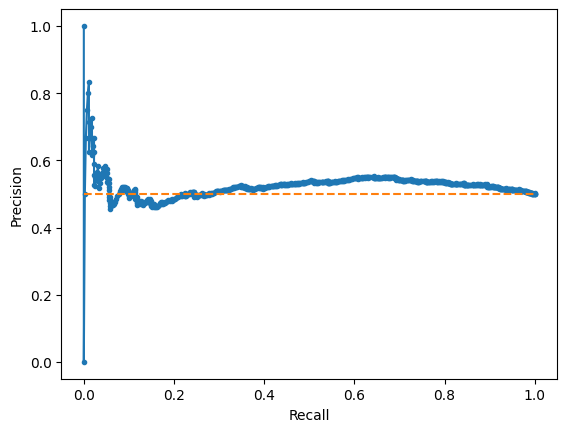

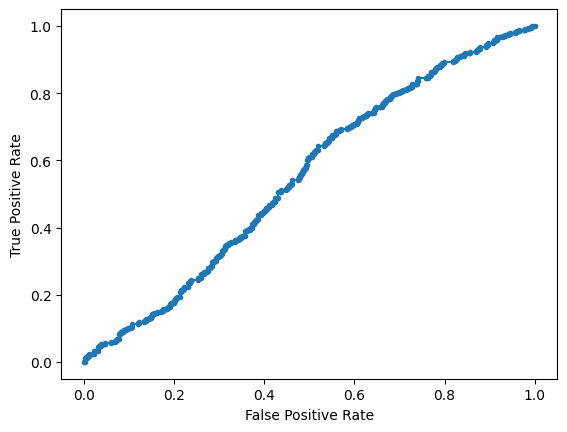

Accuracy: 52.94% Precision: 53.22% Recall: 48.64%
F1: 50.83% MCC: 0.0590
AUPRC: 52.37% AUROC: 54.96%
 accuracy [52.94117647058824]
 precision [53.21782178217822]
 recall [48.64253393665158]
 F1 [50.82742316784869]
 MCC [0.059042134085411715]
 AUPRC [52.370112142184745]
 AUROC [54.962019614668]
2023-04-04 12:23:59.430891

Training # 1 3
2023-04-04 12:23:59.431086
2023-04-04 12:23:59.431166
Discriminator ZERO -1
Train 1:0 750:670 52.82%
Computed class weights: {0: 1.0597014925373134, 1: 0.9466666666666667}
Valid 1:0 442:407 52.06%
FIT
2023-04-04 12:23:59.501284


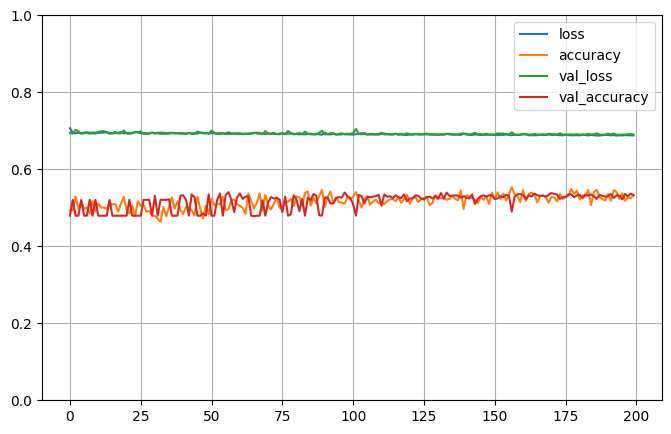


2023-04-04 12:24:41.679239

Testing # 1 3
2023-04-04 12:24:41.679673
2023-04-04 12:24:41.679728
PREDICT
2023-04-04 12:24:41.690187
Test 1:0 442:407 52.06%
Predict 1:0 539:310 63.49%
Test sizes (849, 1025) (849,)
Range of scores: 0.3087547 to 0.5402814
Score threshold 0.5
Confusion matrix
 [[160 247]
 [150 292]]
Normalized matrix
 [[0.18845701 0.29093051]
 [0.17667845 0.34393404]]


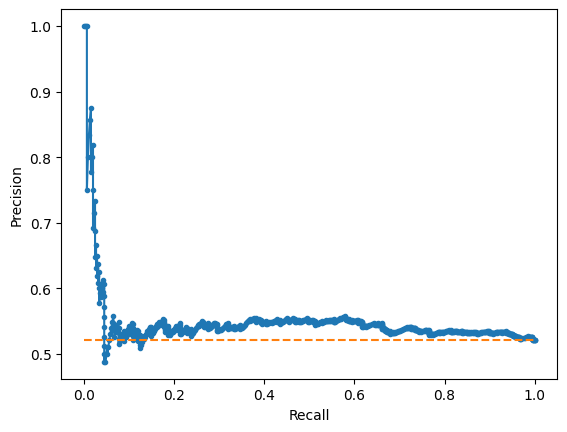

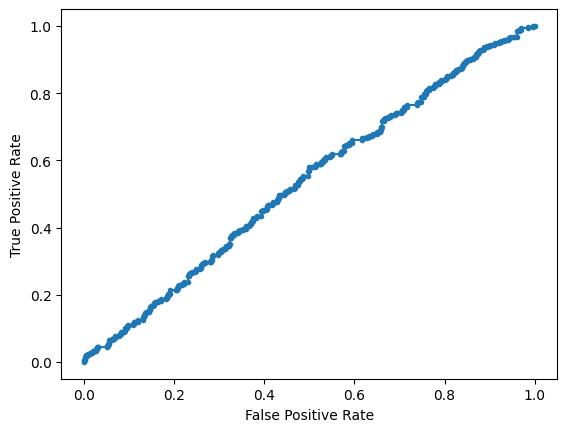

Accuracy: 53.24% Precision: 54.17% Recall: 66.06%
F1: 59.53% MCC: 0.0558
AUPRC: 54.84% AUROC: 53.46%
 accuracy [53.23910482921084]
 precision [54.17439703153989]
 recall [66.06334841628959]
 F1 [59.53109072375127]
 MCC [0.05577542719109754]
 AUPRC [54.838998836372646]
 AUROC [53.45703580997699]
2023-04-04 12:24:42.238605

Training # 1 4
2023-04-04 12:24:42.240391
2023-04-04 12:24:42.240456
Discriminator ZERO -1
Train 1:0 744:639 53.80%
Computed class weights: {0: 1.0821596244131455, 1: 0.9294354838709677}
Valid 1:0 459:431 51.57%
FIT
2023-04-04 12:24:42.308703


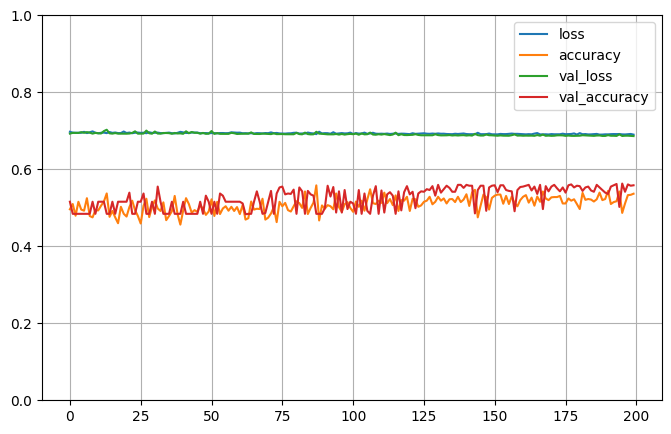


2023-04-04 12:25:24.912679

Testing # 1 4
2023-04-04 12:25:24.912995
2023-04-04 12:25:24.913201
PREDICT
2023-04-04 12:25:24.919684
Test 1:0 459:431 51.57%
Predict 1:0 634:256 71.24%
Test sizes (890, 1025) (890,)
Range of scores: 0.35980076 to 0.5454193
Score threshold 0.5
Confusion matrix
 [[147 284]
 [109 350]]
Normalized matrix
 [[0.16516854 0.31910112]
 [0.12247191 0.39325843]]


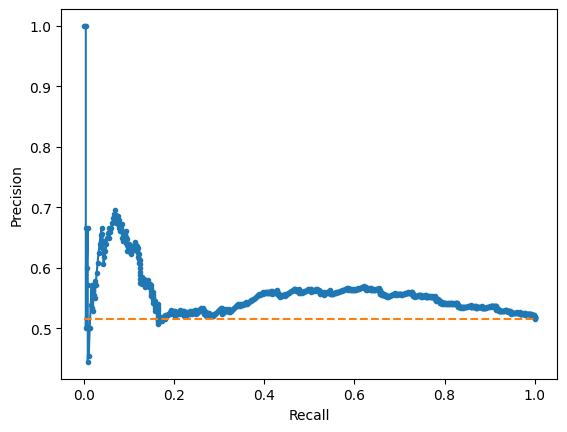

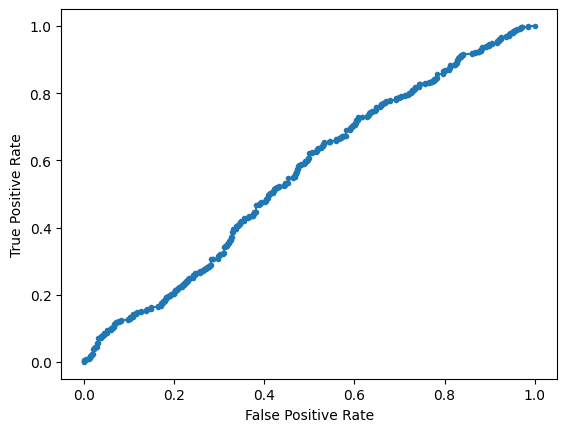

Accuracy: 55.84% Precision: 55.21% Recall: 76.25%
F1: 64.04% MCC: 0.1144
AUPRC: 55.71% AUROC: 55.73%
 accuracy [55.842696629213485]
 precision [55.20504731861199]
 recall [76.25272331154684]
 F1 [64.04391582799634]
 MCC [0.11437132235451483]
 AUPRC [55.71438699384915]
 AUROC [55.73449797552432]
2023-04-04 12:25:25.628819

Training # 1 5
2023-04-04 12:25:25.629563
2023-04-04 12:25:25.629615
Discriminator ZERO -1
Train 1:0 747:656 53.24%
Computed class weights: {0: 1.069359756097561, 1: 0.9390896921017403}
Valid 1:0 457:419 52.17%
FIT
2023-04-04 12:25:25.722176


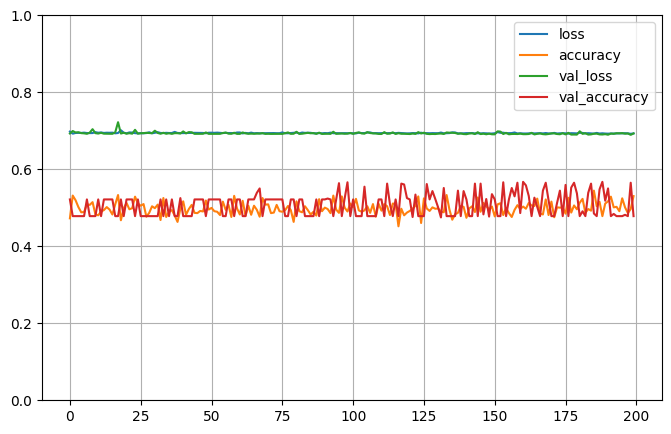


2023-04-04 12:26:10.056767

Testing # 1 5
2023-04-04 12:26:10.058068
2023-04-04 12:26:10.058368
PREDICT
2023-04-04 12:26:10.065544
Test 1:0 457:419 52.17%
Predict 1:0 0:876  0.00%
Test sizes (876, 1025) (876,)
Range of scores: 0.44052076 to 0.4977225
Score threshold 0.5
Confusion matrix
 [[419   0]
 [457   0]]
Normalized matrix
 [[0.4783105 0.       ]
 [0.5216895 0.       ]]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


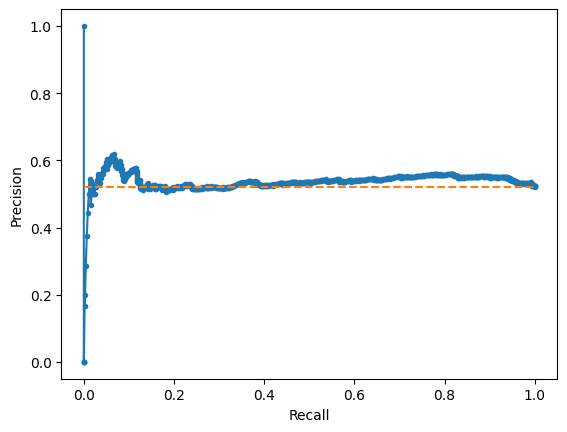

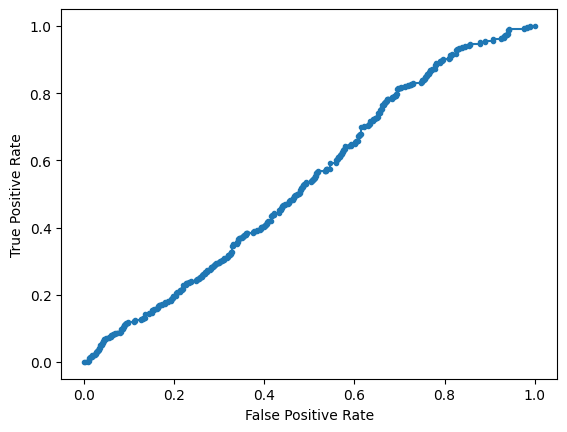

Accuracy: 47.83% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 53.73% AUROC: 53.84%
 accuracy [47.8310502283105]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [53.73013722446384]
 AUROC [53.84289989189641]
2023-04-04 12:26:10.618479

Training # 2 1
2023-04-04 12:26:10.620375
2023-04-04 12:26:10.620522
Discriminator ZERO -1
Train 1:0 737:661 52.72%
Computed class weights: {0: 1.0574886535552193, 1: 0.9484396200814111}
Valid 1:0 472:415 53.21%
FIT
2023-04-04 12:26:10.697030


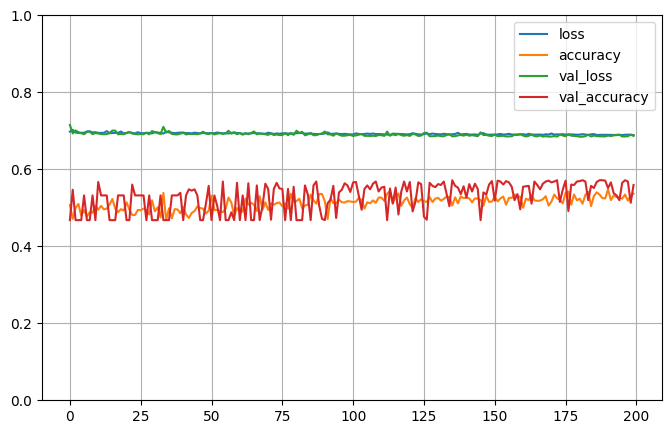


2023-04-04 12:27:33.784668

Testing # 2 1
2023-04-04 12:27:33.786178
2023-04-04 12:27:33.786215
PREDICT
2023-04-04 12:27:33.797097
Test 1:0 472:415 53.21%
Predict 1:0 553:334 62.34%
Test sizes (887, 1025) (887,)
Range of scores: 0.2941137 to 0.5368523
Score threshold 0.5
Confusion matrix
 [[179 236]
 [155 317]]
Normalized matrix
 [[0.20180383 0.26606539]
 [0.17474634 0.35738444]]


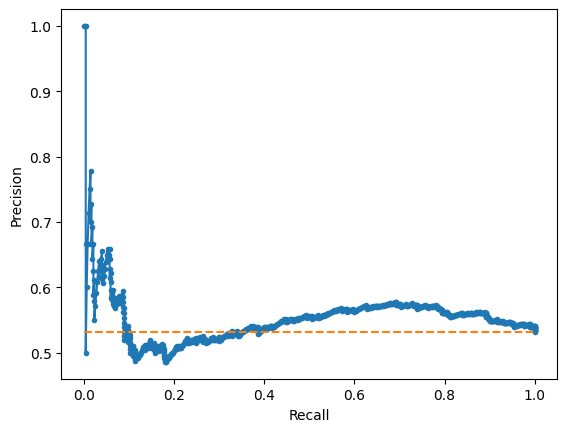

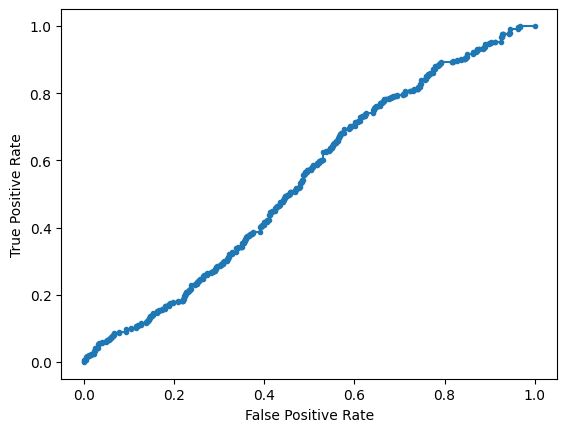

Accuracy: 55.92% Precision: 57.32% Recall: 67.16%
F1: 61.85% MCC: 0.1060
AUPRC: 55.29% AUROC: 53.98%
 accuracy [55.91882750845547]
 precision [57.32368896925859]
 recall [67.16101694915254]
 F1 [61.85365853658536]
 MCC [0.10600450036268468]
 AUPRC [55.29401680544845]
 AUROC [53.97998774760057]
2023-04-04 12:27:34.344166

Training # 2 2
2023-04-04 12:27:34.346110
2023-04-04 12:27:34.346191
Discriminator ZERO -1
Train 1:0 744:665 52.80%
Computed class weights: {0: 1.0593984962406016, 1: 0.9469086021505376}
Valid 1:0 452:416 52.07%
FIT
2023-04-04 12:27:34.419639


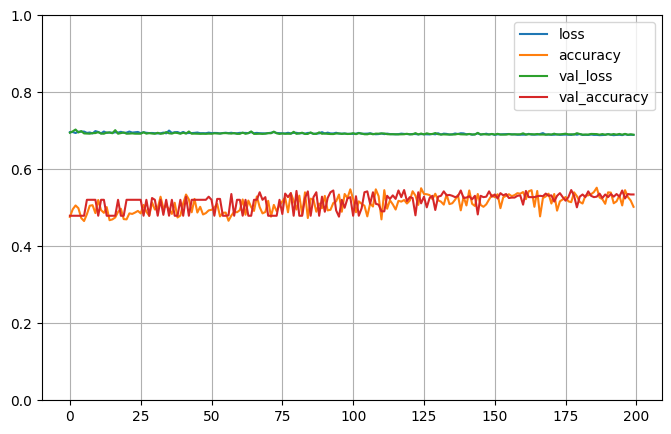


2023-04-04 12:28:57.460578

Testing # 2 2
2023-04-04 12:28:57.461060
2023-04-04 12:28:57.464861
PREDICT
2023-04-04 12:28:57.478990
Test 1:0 452:416 52.07%
Predict 1:0 718:150 82.72%
Test sizes (868, 1025) (868,)
Range of scores: 0.32929054 to 0.5479308
Score threshold 0.5
Confusion matrix
 [[ 81 335]
 [ 69 383]]
Normalized matrix
 [[0.09331797 0.3859447 ]
 [0.07949309 0.44124424]]


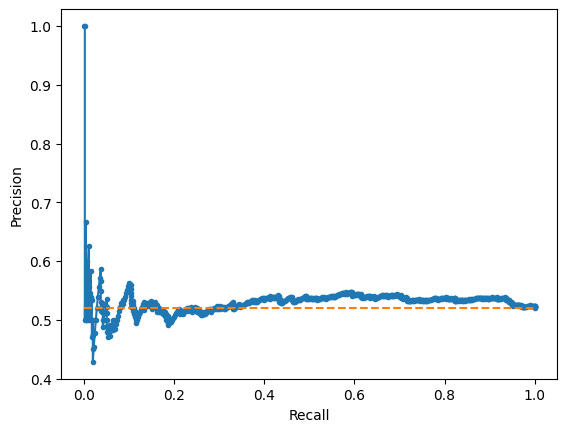

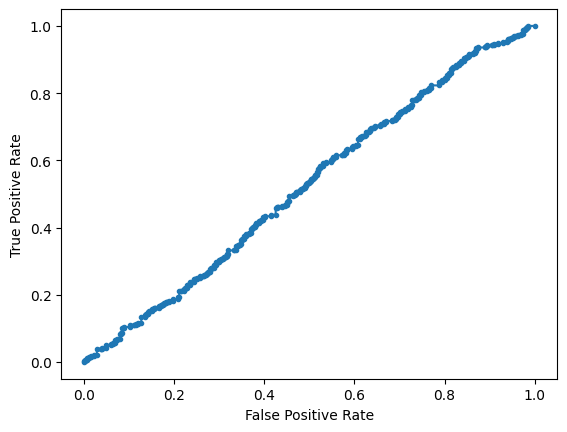

Accuracy: 53.46% Precision: 53.34% Recall: 84.73%
F1: 65.47% MCC: 0.0556
AUPRC: 53.06% AUROC: 52.41%
 accuracy [53.45622119815668]
 precision [53.34261838440112]
 recall [84.7345132743363]
 F1 [65.47008547008546]
 MCC [0.05557032366072931]
 AUPRC [53.06270101420025]
 AUROC [52.41315308032676]
2023-04-04 12:28:58.096612

Training # 2 3
2023-04-04 12:28:58.098315
2023-04-04 12:28:58.098365
Discriminator ZERO -1
Train 1:0 758:653 53.72%
Computed class weights: {0: 1.0803981623277181, 1: 0.9307387862796834}
Valid 1:0 453:407 52.67%
FIT
2023-04-04 12:28:58.236085


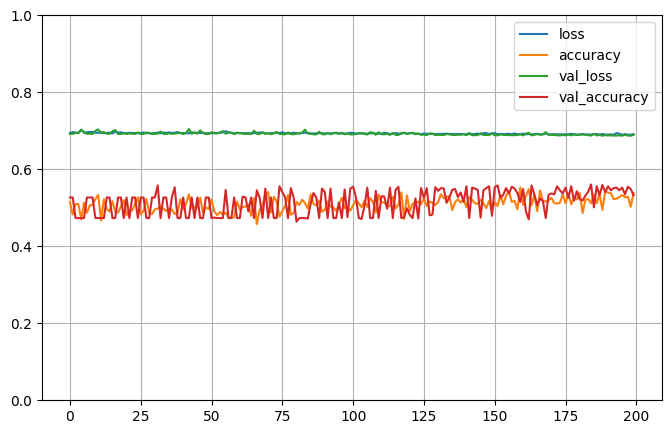


2023-04-04 12:29:41.602754

Testing # 2 3
2023-04-04 12:29:41.604081
2023-04-04 12:29:41.604374
PREDICT
2023-04-04 12:29:41.611863
Test 1:0 453:407 52.67%
Predict 1:0 523:337 60.81%
Test sizes (860, 1025) (860,)
Range of scores: 0.30185118 to 0.5318176
Score threshold 0.5
Confusion matrix
 [[171 236]
 [166 287]]
Normalized matrix
 [[0.19883721 0.2744186 ]
 [0.19302326 0.33372093]]


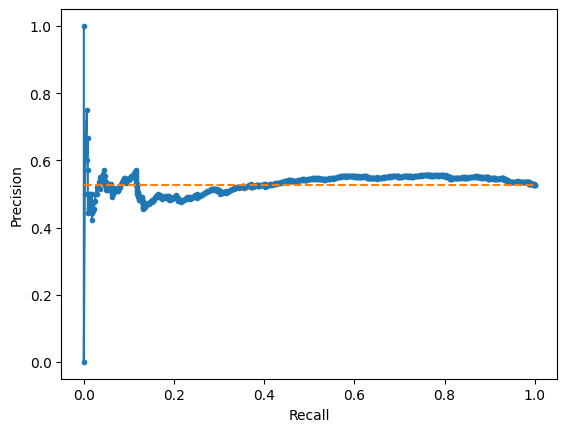

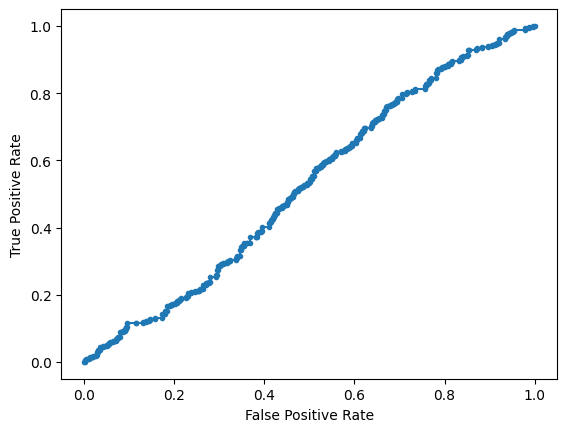

Accuracy: 53.26% Precision: 54.88% Recall: 63.36%
F1: 58.81% MCC: 0.0549
AUPRC: 53.05% AUROC: 52.49%
 accuracy [53.25581395348837]
 precision [54.875717017208416]
 recall [63.35540838852097]
 F1 [58.81147540983606]
 MCC [0.054924607241655744]
 AUPRC [53.04703251826308]
 AUROC [52.488189574282295]
2023-04-04 12:29:42.136860

Training # 2 4
2023-04-04 12:29:42.138288
2023-04-04 12:29:42.138978
Discriminator ZERO -1
Train 1:0 758:640 54.22%
Computed class weights: {0: 1.0921875, 1: 0.9221635883905013}
Valid 1:0 432:447 49.15%
FIT
2023-04-04 12:29:42.203699


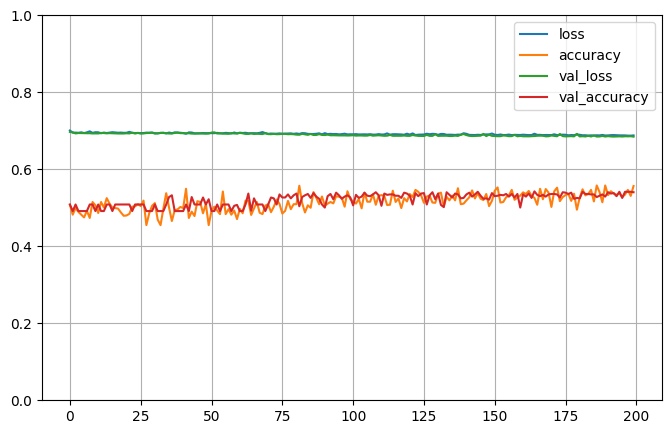


2023-04-04 12:30:24.268158

Testing # 2 4
2023-04-04 12:30:24.268265
2023-04-04 12:30:24.268313
PREDICT
2023-04-04 12:30:24.280136
Test 1:0 432:447 49.15%
Predict 1:0 500:379 56.88%
Test sizes (879, 1025) (879,)
Range of scores: 0.25641388 to 0.5262158
Score threshold 0.5
Confusion matrix
 [[211 236]
 [168 264]]
Normalized matrix
 [[0.24004551 0.26848692]
 [0.19112628 0.3003413 ]]


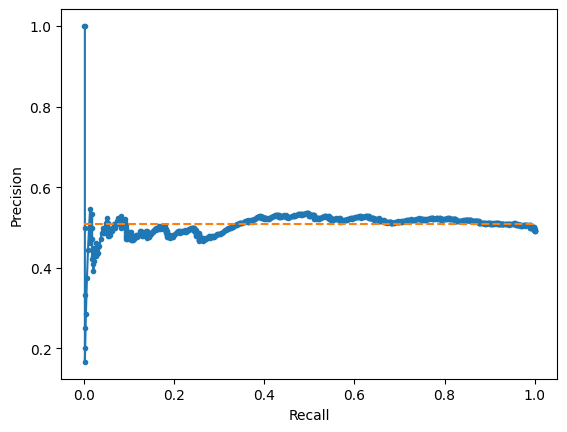

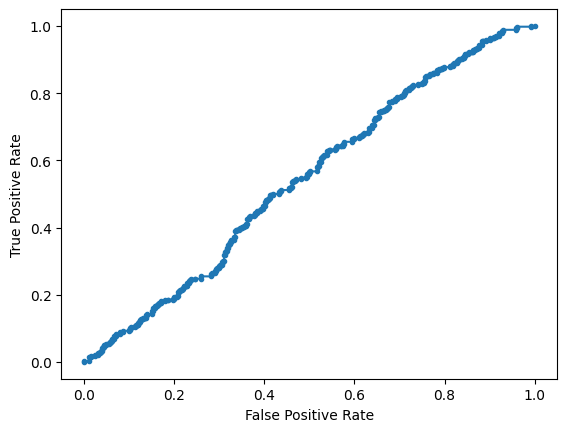

Accuracy: 54.04% Precision: 52.80% Recall: 61.11%
F1: 56.65% MCC: 0.0839
AUPRC: 50.84% AUROC: 54.32%
 accuracy [54.0386803185438]
 precision [52.800000000000004]
 recall [61.111111111111114]
 F1 [56.65236051502146]
 MCC [0.0839338447688113]
 AUPRC [50.83636495956885]
 AUROC [54.31710373684647]
2023-04-04 12:30:24.781289

Training # 2 5
2023-04-04 12:30:24.783105
2023-04-04 12:30:24.783470
Discriminator ZERO -1
Train 1:0 743:653 53.22%
Computed class weights: {0: 1.0689127105666156, 1: 0.9394347240915208}
Valid 1:0 449:426 51.31%
FIT
2023-04-04 12:30:24.842953


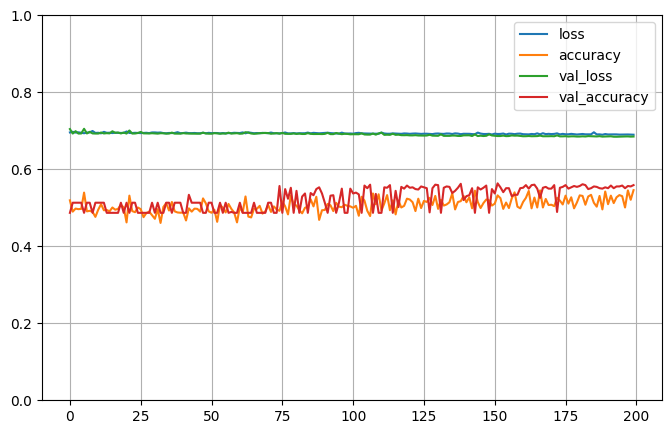


2023-04-04 12:31:06.887808

Testing # 2 5
2023-04-04 12:31:06.887944
2023-04-04 12:31:06.887991
PREDICT
2023-04-04 12:31:06.903097
Test 1:0 449:426 51.31%
Predict 1:0 509:366 58.17%
Test sizes (875, 1025) (875,)
Range of scores: 0.328335 to 0.5240594
Score threshold 0.5
Confusion matrix
 [[203 223]
 [163 286]]
Normalized matrix
 [[0.232      0.25485714]
 [0.18628571 0.32685714]]


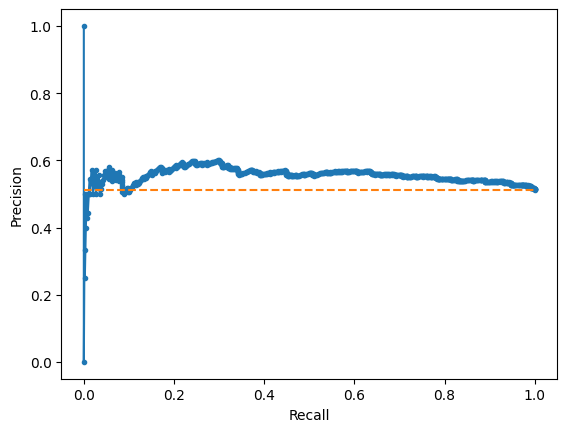

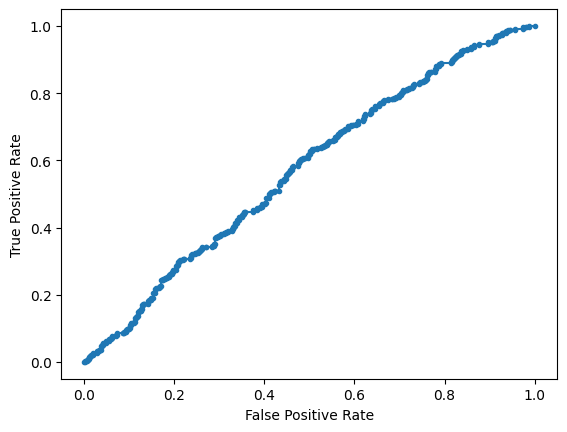

Accuracy: 55.89% Precision: 56.19% Recall: 63.70%
F1: 59.71% MCC: 0.1150
AUPRC: 55.45% AUROC: 57.16%
 accuracy [55.885714285714286]
 precision [56.188605108055015]
 recall [63.69710467706013]
 F1 [59.707724425887264]
 MCC [0.11500385931823337]
 AUPRC [55.45298480020817]
 AUROC [57.16354548971631]
2023-04-04 12:31:07.919182


In [23]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [24]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 53.36% std 2.48
 precision mean 49.13% std 17.32
 recall mean 57.82% std 23.18
 F1 mean 52.73% std 19.18
 MCC mean 0.07% std 0.04
 AUPRC mean 53.77% std 1.56
 AUROC mean 54.23% std 1.44
 accuracy [[51.14942528735632], [52.94117647058824], [53.23910482921084], [55.842696629213485], [47.8310502283105], [55.91882750845547], [53.45622119815668], [53.25581395348837], [54.0386803185438], [55.885714285714286]]
 precision [[54.13533834586466], [53.21782178217822], [54.17439703153989], [55.20504731861199], [0.0], [57.32368896925859], [53.34261838440112], [54.875717017208416], [52.800000000000004], [56.188605108055015]]
 recall [[47.161572052401745], [48.64253393665158], [66.06334841628959], [76.25272331154684], [0.0], [67.16101694915254], [84.7345132743363], [63.35540838852097], [61.111111111111114], [63.69710467706013]]
 F1 [[50.40840140023337], [50.82742316784869], [59.53109072375127], [64.04391582799634], [0.0], [61.85365853658536], [65.47008547008546], [58.81147540983606], [5